# Time Series

## Imports

In [1]:
%config InlineBackend.figure_format="retina"

In [60]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

## An overview of time series problems

Time series userful when there is:

- A trend
- Seasonality
- The current point infroms the next point—where
  noise or residuals are correlated
  
$$
y_t = \text{Trend}_t + \text{Seasonality}_t + \text{Residuals}_t
$$

## Time series analysis as a regression problem

In [43]:
co2_by_month

,CO2
date_month,
1966-01-01,320.62
1966-02-01,321.60
1966-03-01,322.39
1966-04-01,323.70
1966-05-01,324.08
...,...
2018-09-01,405.52
2018-10-01,405.93
2018-11-01,408.05


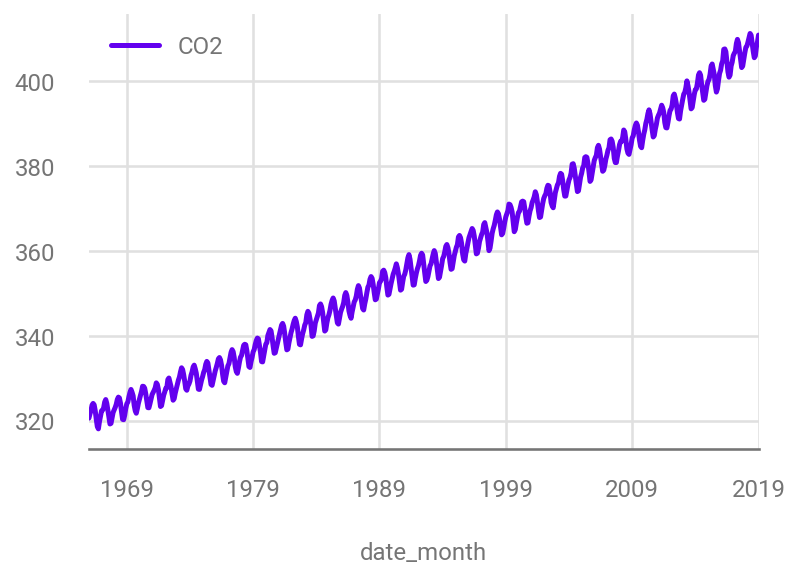

In [44]:
co2_by_month = (
    pd.read_csv(
        "https://raw.githubusercontent.com"
        "/BayesianModelingandComputationInPython/BookCode_Edition1/main"
        "/data/monthly_mauna_loa_co2.csv",
        parse_dates=["date_month"],
    )
    .set_index("date_month")
    .assign(CO2=lambda df: df["CO2"].astype("float32"))
)
num_forecast_steps = 12 * 10
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]
co2_by_month_testing_data = co2_by_month[-num_forecast_steps:]
co2_by_month.plot.line();

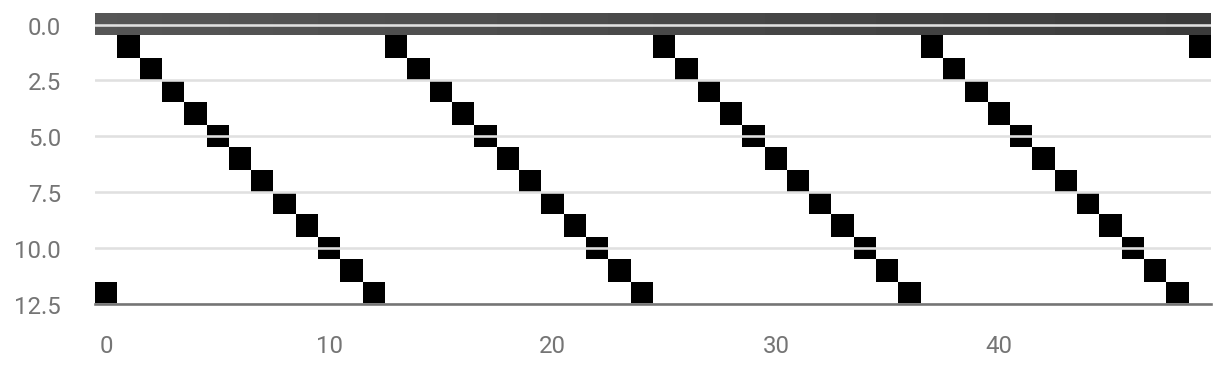

In [50]:
trend_all = np.linspace(0.0, 1.0, co2_by_month.shape[0])[..., None].astype("float32")
trend = trend_all[:-num_forecast_steps, :]
seasonality_all = pd.get_dummies(co2_by_month.index.month).to_numpy().astype("float32")
seasonality = seasonality_all[:-num_forecast_steps, :]
_, ax = plt.subplots(figsize=(10, 4))
X_subset = np.concatenate([trend, seasonality], axis=-1)[-50:]
ax.imshow(X_subset.T, cmap="Greys");

In [46]:
seasonality_all

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Typical cyclical information,
in order of resolution:

1. Second of the hour (1, 2, …, 60)
2. Hour of the day (1, 2, …, 24)
3. Day of the week (Monday, Tuesday, …, Sunday)
4. Day of the month(1, 2, …, 31)
5. Holiday effect (New year's, etc)
6. Month of the year (1, 2, …, 12)

Day of the week and month
are usually cloesly correlated with human activities—like
passenger numbers of public transportation.

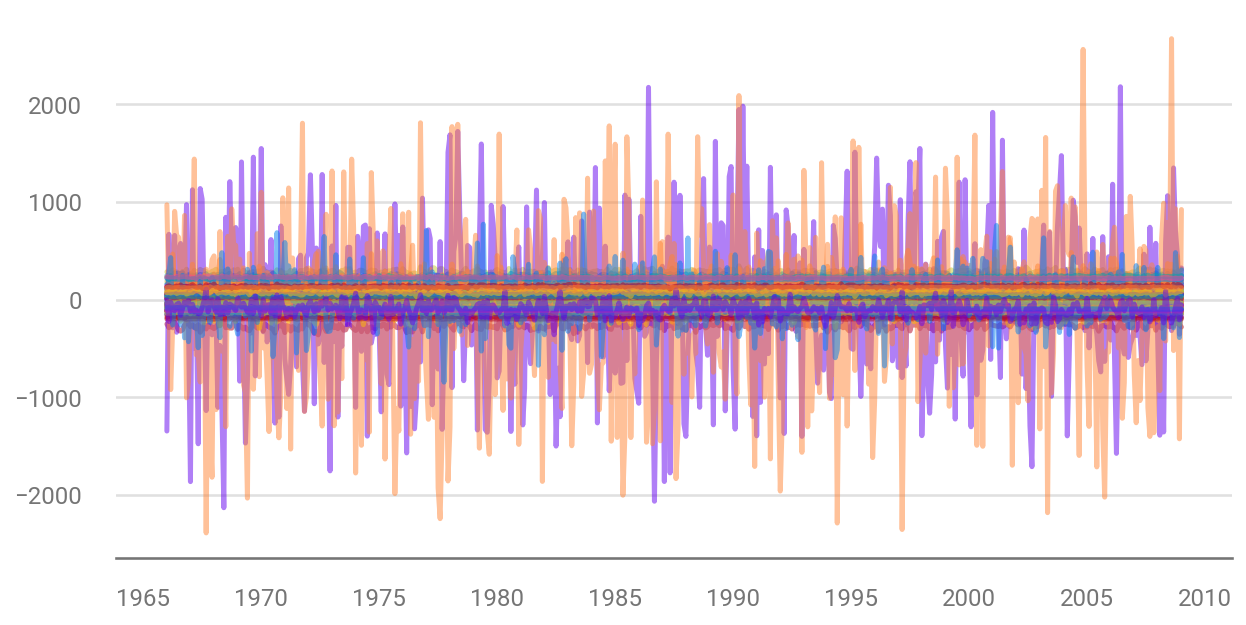

In [41]:
root = tfd.JointDistributionCoroutine.Root


@tfd.JointDistributionCoroutine
def ts_regression_model():
    intercept = yield root(tfd.Normal(0.0, 100.0, name="intercept"))
    trend_coeff = yield root(tfd.Normal(0.0, 10.0, name="trend_coeff"))
    seasonality_coeff = yield root(
        tfd.Sample(
            tfd.Normal(0.0, 1.0),
            sample_shape=seasonality.shape[-1],
            name="seasonality_coeff",
        )
    )
    noise = yield root(tfd.HalfCauchy(loc=0.0, scale=5.0, name="noise_sigma"))
    y_hat = (
        intercept[..., None]
        + tf.einsum("ij,...->...i", trend, trend_coeff)
        + tf.einsum("ij,...j->...i", seasonality, seasonality_coeff)
    )
    observed = yield tfd.Independent(
        tfd.Normal(y_hat, noise[..., None]),
        reinterpreted_batch_ndims=1,
        name="observed",
    )


prior_samples = ts_regression_model.sample(100)
prior_predictive_timeseries = prior_samples.observed
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    co2_by_month.index[:-num_forecast_steps],
    tf.transpose(prior_predictive_timeseries),
    alpha=0.5,
);

Each line plot is one simulated time series for prior predictive.
Prediction has a wide range due to uniformative prior.

2022-05-28 12:56:20.013864: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


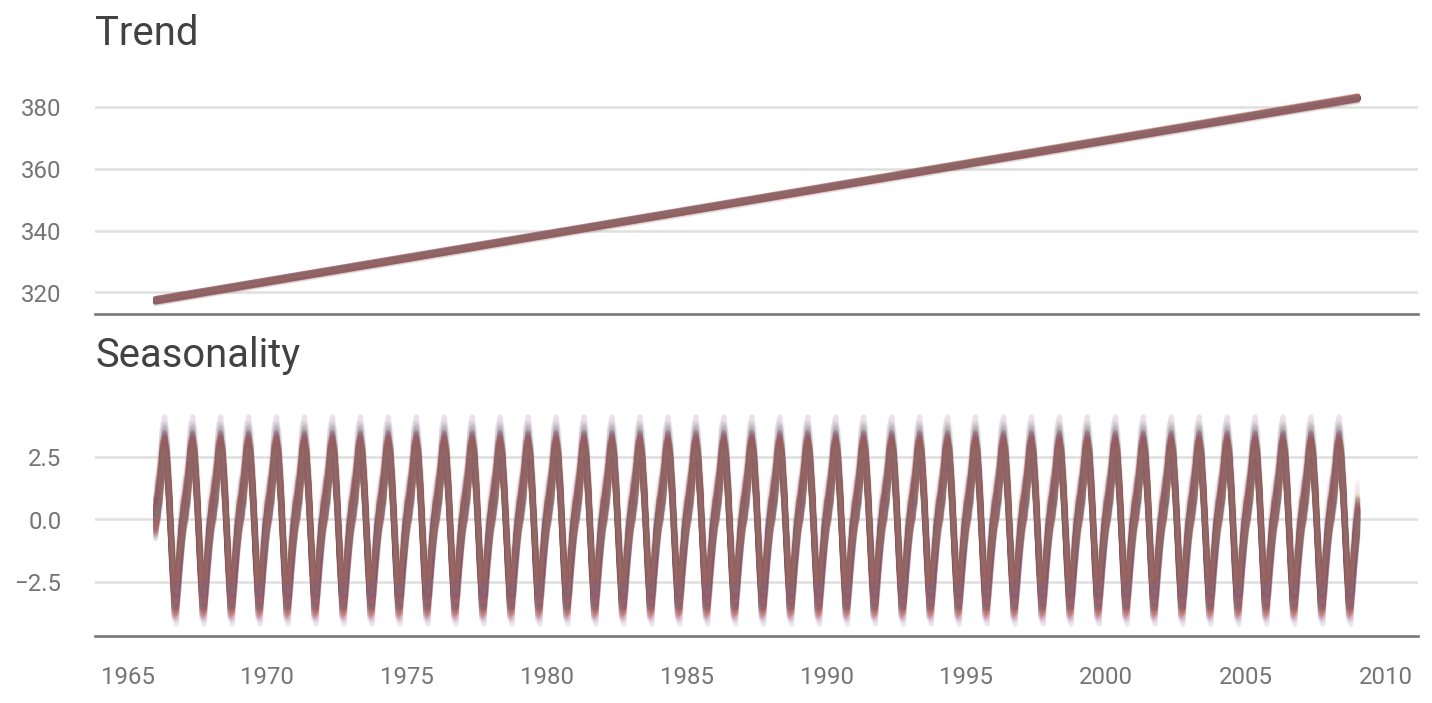

In [56]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts, autograph=False, jit_compile=True
)
mcmc_samples, sampler_stats = run_mcmc(
    1_000,
    ts_regression_model,
    n_chains=4,
    num_adaptation_steps=1_000,
    observed=co2_by_month_training_data["CO2"].values[None, ...],
)
regression_idata = az.from_dict(
    posterior={
        k: np.swapaxes(v.numpy(), 1, 0) for k, v in mcmc_samples._asdict().items()
    },
    sample_stats={
        k: np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    },
)
nchains = regression_idata.posterior.dims["chain"]
trend_posterior = mcmc_samples.intercept + tf.einsum(
    "ij,...->i...", trend_all, mcmc_samples.trend_coeff
)
seasonality_posterior = tf.einsum(
    "ij,...j->i...", seasonality_all, mcmc_samples.seasonality_coeff
)
y_hat = trend_posterior + seasonality_posterior
posterior_predictive_dist = tfd.Normal(y_hat, mcmc_samples.noise_sigma)
posterior_predictive_samples = posterior_predictive_dist.sample()

_, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
for i in range(nchains):
    top_ax.plot(
        co2_by_month.index[:-num_forecast_steps],
        trend_posterior[:-num_forecast_steps, -100:, i],
        alpha=0.05,
    )
    bottom_ax.plot(
        co2_by_month.index[:-num_forecast_steps],
        seasonality_posterior[:-num_forecast_steps, -100:, i],
        alpha=0.05,
    )
top_ax.set_title("Trend")
bottom_ax.set_title("Seasonality")
plt.tight_layout();

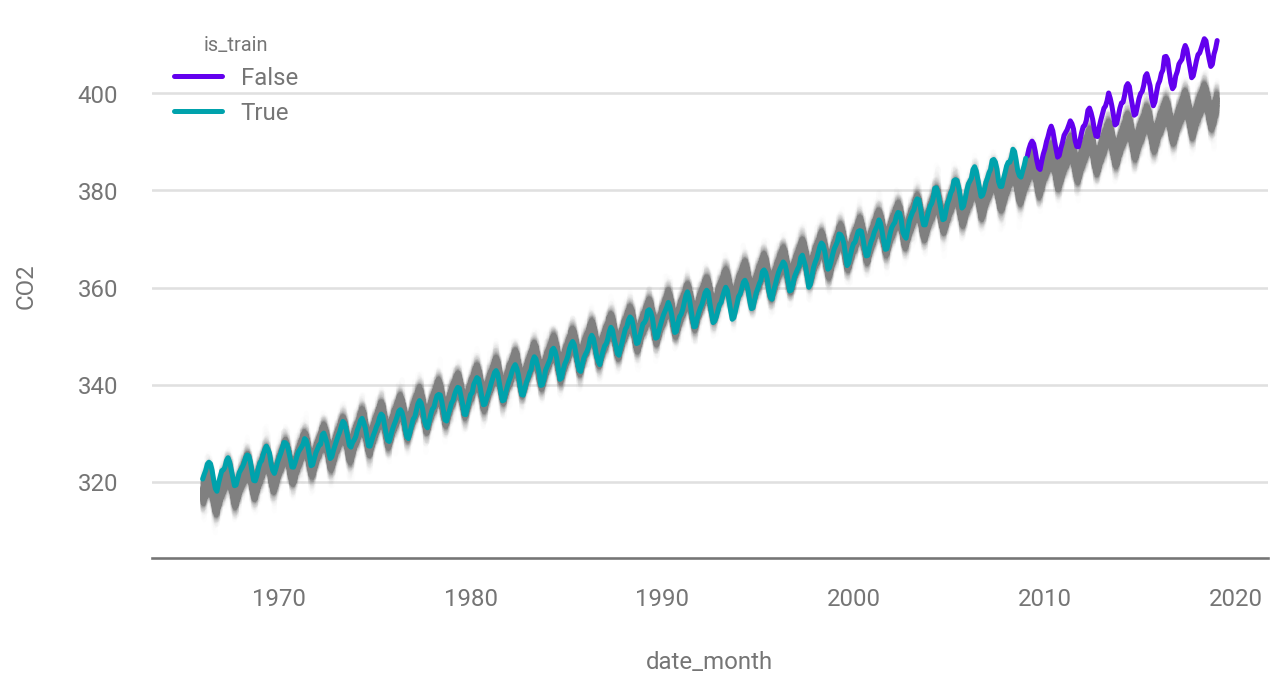

In [68]:
_, ax = plt.subplots(figsize=(10, 5))
sample_shape = posterior_predictive_samples.shape[1:]
ax.plot(
    co2_by_month.index,
    tf.reshape(posterior_predictive_samples, [-1, tf.math.reduce_prod(sample_shape)])[
        :, :500
    ],
    color="gray",
    alpha=0.01,
)
(
    co2_by_month.assign(
        is_train=lambda df: df.index.isin(co2_by_month.iloc[:-num_forecast_steps].index)
    )
    .reset_index()
    .pipe((sns.lineplot, "data"), x="date_month", y="CO2", hue="is_train", ax=ax)
);

Some problems

1. Linear trend does not perform well further into the future.
  Is consistently lower than reality.
2. The range of uncertainty is almost constant.
  We expect uncertainty to increase
  when we forecast further into the future.